## Scraping IGC data and Visualizing

In [4]:
# 0. Load packages

import geopandas as gpd
import contextily as ctx
from shapely.geometry import LineString, Point

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar

import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime
import time
import json
import requests

import srtm

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
# 1. Load master metadata file (all flights, irrespective if IGC file exists), filter for paragliders only

metadata = pd.read_csv("Flight data/metadata.csv")

# Filter for only confirmed paraglider flights (no fixed wings or unknown)
paragliders_df = metadata[metadata["glider_cat"].str.contains("Paraglider", na=False)]

print(f"Cleaned dataset: {len(paragliders_df)} rows (from {len(metadata)} originally).")

metadata = paragliders_df

Cleaned dataset: 4745 rows (from 4973 originally).


In [ ]:
# 2. Fetch IGC files via API for all metadata flights if they exist (log missing IGC files to prevent re-checking)
# Check for known missing IGC files (JSON file), skip those. Skip already-downloaded IGC files.

# --- Config ---
BASE = "https://www.paraglidingforum.com"
session = requests.Session()
session.headers.update({"User-Agent": "Mozilla/5.0"})

IGC_DIR = Path("Flight data/igc")
NO_IGC_FILE = Path("Flight data/no_igc.json")

def load_no_igc() -> set[int]:
    """Load newline-separated IDs (not JSON)."""
    if NO_IGC_FILE.exists():
        ids = set()
        for line in NO_IGC_FILE.read_text(encoding="utf-8").splitlines():
            line = line.strip()
            if line.isdigit():
                ids.add(int(line))
        return ids
    return set()

def append_no_igc(new_ids: set[int]) -> None:
    """Append IDs as plain lines (newline-separated)."""
    if not new_ids:
        return
    NO_IGC_FILE.parent.mkdir(parents=True, exist_ok=True)
    with open(NO_IGC_FILE, "a", encoding="utf-8") as f:
        for fid in sorted(new_ids):
            f.write(f"{fid}\n")

def download_igc(flight_id: int, to_path: Path) -> bool:
    """
    Download the raw .igc GPS log for a given flight from Leonardo.
    """
    igc_url = f"{BASE}/leonardo/download.php?type=igc&flightID={flight_id}"

    try:
        r = session.get(igc_url, timeout=60)
        r.raise_for_status()
    except Exception as e:
        print(f"❌ Failed to fetch IGC for flight {flight_id}: {e}")
        return False

    # Quick sanity check: IGC files usually start with A/H/B lines
    if not r.text.strip().startswith(("A", "H", "B")):
        print(f"⚠️ Invalid IGC response for flight {flight_id}")
        return False

    to_path.parent.mkdir(parents=True, exist_ok=True)
    with open(to_path, "wb") as f:
        f.write(r.content)

    print(f"💾 Saved IGC for flight {flight_id} -> {to_path}")
    return True


if __name__ == "__main__":
    no_igc_ids = load_no_igc()
    print(f"▶︎ start | known no-IGC: {len(no_igc_ids)}")

    for flight_id in map(int, metadata["flight_id"]):
        if flight_id in no_igc_ids:
            continue  # skip known-missing

        out_file = IGC_DIR / f"flight_{flight_id}.igc"
        if out_file.exists():
            continue  # already have it

        ok = download_igc(flight_id, out_file)
        if not ok:
            # append-only add of the *new* ID
            if flight_id not in no_igc_ids:
                append_no_igc({flight_id})
                no_igc_ids.add(flight_id)

        time.sleep(0.5)  # be nice to the server

    print(f"✅ done | total known no-IGC: {len(no_igc_ids)} | igc files on disk: {len(list(IGC_DIR.glob('*.igc')))}")

▶︎ start | known no-IGC: 323
💾 Saved IGC for flight 3523105 -> Flight data/igc/flight_3523105.igc
💾 Saved IGC for flight 3478638 -> Flight data/igc/flight_3478638.igc
💾 Saved IGC for flight 3478186 -> Flight data/igc/flight_3478186.igc
💾 Saved IGC for flight 3477990 -> Flight data/igc/flight_3477990.igc
💾 Saved IGC for flight 3477803 -> Flight data/igc/flight_3477803.igc
💾 Saved IGC for flight 3523106 -> Flight data/igc/flight_3523106.igc
💾 Saved IGC for flight 3477988 -> Flight data/igc/flight_3477988.igc
💾 Saved IGC for flight 3477332 -> Flight data/igc/flight_3477332.igc
💾 Saved IGC for flight 3477016 -> Flight data/igc/flight_3477016.igc
💾 Saved IGC for flight 3468406 -> Flight data/igc/flight_3468406.igc
💾 Saved IGC for flight 3468430 -> Flight data/igc/flight_3468430.igc
💾 Saved IGC for flight 3517915 -> Flight data/igc/flight_3517915.igc
💾 Saved IGC for flight 3468429 -> Flight data/igc/flight_3468429.igc
💾 Saved IGC for flight 3463793 -> Flight data/igc/flight_3463793.igc
💾 Sav

In [ ]:
# 3. Load IGC files, enrich with thermal features, add date from metadata, store as CSV (folder enriched_csv)
# Identifies thermals based on climb rate > 0.5 m/s and turn rate > 3 deg/s (both smoothed over 5s)

# Load SRTM once globally (altitude map needed for ALG calculation)
srtm_data = srtm.get_data()

# Earth radius (for ground speed calculation)
R_EARTH = 6371000  # meters

# Calculate Bearing (from two GPS points)
def bearing(lat1, lon1, lat2, lon2):
    dlon = np.radians(lon2 - lon1)
    lat1, lat2 = np.radians(lat1), np.radians(lat2)
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    return (np.degrees(np.arctan2(x, y)) + 360) % 360

def load_coords_from_igc(path: Path) -> pd.DataFrame:
    """
    Extract GPS fixes from an IGC file and return as DataFrame
    with time (UTC), latitude, longitude, and altitude.
    """
    coords = []

    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if not line.startswith("B"):
                continue  # skip headers & non-fix lines

            # Time (HHMMSS)
            # Merge date into df
            hh = int(line[1:3]); mm = int(line[3:5]); ss = int(line[5:7])
            timestamp = datetime.strptime(f"{hh:02d}{mm:02d}{ss:02d}", "%H%M%S").time()

            # Latitude
            lat_deg = int(line[7:9])
            lat_min = float(line[9:14]) / 1000.0
            lat = lat_deg + lat_min / 60.0
            if line[14] == "S": lat = -lat

            # Longitude
            lon_deg = int(line[15:18])
            lon_min = float(line[18:23]) / 1000.0
            lon = lon_deg + lon_min / 60.0
            if line[23] == "W": lon = -lon

            # Altitude (last 5 chars)
            alt = int(line[30:35])

            coords.append((timestamp, lat, lon, alt))

    return pd.DataFrame(coords, columns=["time_utc", "lat", "lon", "alt"])

def preprocess_flight(df: pd.DataFrame, flight_id: int) -> pd.DataFrame:
    """
    Add climb rate, smoothed climb, bearing, turn rate, terrain alt, AGL,
    ground speed, turn radius, and thermal detection flags.
    """
    df = df.copy()
    df["flight_id"] = flight_id

    df["time_sec"] = df.index
    df["time_min"] = df["time_sec"] / 60.0

    # --- Terrain altitude & AGL ---
    df["terrain_alt"] = [
        srtm_data.get_elevation(lat, lon) or np.nan
        for lat, lon in zip(df["lat"], df["lon"])
    ]
    df["terrain_alt"] = df["terrain_alt"].interpolate()
    df["agl"] = (df["alt"] - df["terrain_alt"]).clip(lower=0)

    # --- Climb rate ---
    df["climb_rate"] = df["alt"].diff() / 1.0
    df["climb_rate_smooth"] = df["climb_rate"].rolling(window=5, center=True).mean()

    # --- Bearing ---
    df["bearing"] = bearing(df["lat"].shift(), df["lon"].shift(),
                            df["lat"], df["lon"])
    df["bearing"] = df["bearing"].ffill()

    # --- Turn rate ---
    df["turn_rate"] = (df["bearing"] - df["bearing"].shift()).fillna(0)
    df["turn_rate"] = ((df["turn_rate"] + 180) % 360) - 180
    df["turn_rate_smooth"] = df["turn_rate"].rolling(window=5, center=True).mean()

    # --- Ground speed (haversine distance per second) ---
    lat_rad = np.radians(df["lat"])
    lon_rad = np.radians(df["lon"])
    dlat = lat_rad.diff().fillna(0)
    dlon = lon_rad.diff().fillna(0)

    a = np.sin(dlat/2)**2 + np.cos(lat_rad) * np.cos(lat_rad.shift().fillna(lat_rad.iloc[0])) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    df["ground_speed"] = R_EARTH * c  # m/s

    # --- Angular velocity (rad/s) ---
    df["ang_vel"] = np.radians(df["turn_rate_smooth"])

    # --- Optional: Clip to physically realistic range ---
    df["turn_radius"] = df["turn_radius"].clip(lower=5, upper=1000)

    # --- Thermal detection ---
    df["thermal_flag_smooth"] = (
        (df["climb_rate_smooth"].rolling(10, center=True).mean() > 0.5) &
        (df["turn_rate_smooth"].rolling(10, center=True).mean().abs() > 3)
    ).astype(int)

    # Assign segment IDs (increment when entering a thermal)
    df["thermal_segment"] = (df["thermal_flag_smooth"].diff() == 1).cumsum()
    df.loc[df["thermal_flag_smooth"] == 0, "thermal_segment"] = np.nan

    

    return df

def add_datetime(df: pd.DataFrame, flight_id: int, meta: pd.DataFrame) -> pd.DataFrame:
    """
    Merge metadata date with time_utc to build a full datetime column.
    Assumes df has 'time_utc' (from IGC) and meta has 'date' + 'flight_id'.
    """
    # Get flight date from metadata
    flight_date = meta.loc[meta["flight_id"] == flight_id, "date"].values
    if len(flight_date) == 0:
        raise ValueError(f"No date found in metadata for flight_id {flight_id}")
    
    flight_date = pd.to_datetime(str(flight_date[0])).date()

    # Combine date + time_utc into full datetime
    df = df.copy()
    df["datetime"] = pd.to_datetime(
        df["time_utc"].astype(str).apply(lambda t: f"{flight_date} {t}")
    )
    df = df.drop(columns=["time_utc"])

    return df


### Usage

IGC_DIR = Path("Flight data/igc")
OUT_DIR = Path("Flight data/enriched_csv")
OUT_DIR.mkdir(parents=True, exist_ok=True)

saved = 0
errors = []
max_files = 500000 # Keep low for testing

# Loop through all IGC files
for i, igc_path in enumerate(IGC_DIR.glob("*.igc")):
    if i >= max_files:
        break
    try:
        # Extract flight_id from filename (e.g. flight_3495727.igc -> 3495727)
        flight_id = int(igc_path.stem.split("_")[1])

        # Load IGC raw coordinates
        df = load_coords_from_igc(igc_path)

        # Add datetime using metadata
        df = add_datetime(df, flight_id=flight_id, meta=metadata)

        # Enrich with climb rate, turn rate, etc.
        df = preprocess_flight(df, flight_id=flight_id)


        # Save as CSV
        out_path = OUT_DIR / f"flight_{flight_id}.csv"
        df.to_csv(out_path, index=False)

        saved += 1

    except Exception as e:
        errors.append((igc_path.name, str(e)))

# Print Summary 
print(f"✅ Saved {saved} flights to {OUT_DIR}")
if errors:
    print(f"⚠️ {len(errors)} flights failed:")
    for fname, msg in errors:
        print(f"   - {fname}: {msg}")


4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
4 2884802
✅ Saved 965 flights to Flight data/enriched_parquet


In [29]:
# 4. Extract thermals from enriched CSVs, merge and filter, combine and store as one data frame (thermals_master.csv)

def merge_close_thermals(thermals, gap_s=10):
    """
    Merge consecutive thermal segments if the time gap between them
    is <= gap_s seconds. Weighted averages are recomputed.
    """
    thermals = thermals.sort_values(["flight_id", "start_time"]).reset_index(drop=True)
    merged = []
    current = thermals.iloc[0].copy()

    for i in range(1, len(thermals)):
        row = thermals.iloc[i]
        same_flight = row.flight_id == current.flight_id
        small_gap = (row.start_time - current.end_time) <= gap_s

        if same_flight and small_gap:
            # Extend current thermal
            total_dur = current.duration_s + row.duration_s

            # Weighted averages (duration as weight)
            for col in ["avg_climb", "climb_std", "avg_turn_radius", "avg_turn", "turn_std"]:
                if pd.notna(current[col]) and pd.notna(row[col]):
                    current[col] = (
                        current[col] * current.duration_s + row[col] * row.duration_s
                    ) / total_dur

            # Update end time and duration
            current.end_time = row.end_time
            current.duration_s = total_dur

            # Update altitude
            current.alt_gain += row.alt_gain
            current.exit_alt = row.exit_alt

            # Update center (mean lat/lon of combined)
            current.lat_center = (current.lat_center + row.lat_center) / 2
            current.lon_center = (current.lon_center + row.lon_center) / 2

        else:
            merged.append(current)
            current = row.copy()

    merged.append(current)
    return pd.DataFrame(merged).reset_index(drop=True)

OUT_DIR = Path("/Users/moritzknodler/Documents/00_Lectures/0_Fall 2025/ML/z_Project/Flight data/enriched_csv")
OUT_DIR.mkdir(parents=True, exist_ok=True)

THERMALS_OUT = Path("Flight data/thermals")
THERMALS_OUT.mkdir(parents=True, exist_ok=True)

all_thermals = []   # will hold per-flight thermal DataFrames
errors = []

# Loop through enriched CSVs
for csv_path in OUT_DIR.glob("*.csv"):
    try:
        # Load flight data
        df = pd.read_csv(csv_path, parse_dates=["datetime"])
        flight_id = int(csv_path.stem.split("_")[1])

        # Skip flights without thermals
        if df["thermal_segment"].dropna().empty:
            continue

        # --- Extract raw thermals ---
        thermals = (
            df[df["thermal_segment"] > 0]
            .groupby("thermal_segment")
            .agg(
                flight_id=("flight_id", "first"),
                start_datetime=("datetime", "first"),
                start_time=("time_sec", "min"),
                end_time=("time_sec", "max"),
                duration_s=("time_sec", lambda x: x.max() - x.min()),
                avg_climb=("climb_rate_smooth", "mean"),
                max_climb=("climb_rate_smooth", "max"),
                climb_std=("climb_rate_smooth", lambda x: np.nanstd(x)),
                avg_turn_radius=("turn_radius", lambda x: np.nanmean(x) if len(x.dropna()) > 0 else np.nan),
                avg_turn=("turn_rate_smooth", "mean"),
                turn_std=("turn_rate_smooth", "std"),
                lat_center=("lat", "mean"),
                lon_center=("lon", "mean"),
            # --- ALT & AGL together ---
                entry_alt=("alt", lambda x: x.iloc[0] if len(x) > 0 else np.nan),
                exit_alt=("alt", lambda x: x.iloc[-1] if len(x) > 0 else np.nan),
                entry_agl=("agl", lambda x: x.iloc[0] if len(x) > 0 else np.nan),
                exit_agl=("agl", lambda x: x.iloc[-1] if len(x) > 0 else np.nan),
                entry_terrain_alt =("terrain_alt", lambda x: x.iloc[0] if len(x) > 0 else np.nan),

                alt_gain=("alt", lambda x: x.iloc[-1] - x.iloc[0] if len(x) > 1 else np.nan),
                thermal_quality=("climb_rate_smooth", 
                                 lambda x: x.mean() * (x.index.max() - x.index.min()) if len(x) > 0 else np.nan)
            )
            .reset_index(drop=True)
        )

        # --- Merge close thermals ---
        thermals = merge_close_thermals(thermals, gap_s=30)

        # --- Filter ---
        thermals = thermals[
            (thermals["duration_s"] >= 15) &
            (thermals["alt_gain"] >= 20) &
            (thermals["avg_climb"] > 0.5)
        ].reset_index(drop=True)

        if not thermals.empty:
            all_thermals.append(thermals)

    except Exception as e:
        errors.append((csv_path.name, str(e)))



# Save Master Thermals DF
if all_thermals:
    thermals_master = pd.concat(all_thermals, ignore_index=True)

    #Sort thermals by start_datetime and Add unique thermal_id at the beginning of the DataFrame
    thermals_master = thermals_master.sort_values(by="start_datetime").reset_index(drop=True)
    thermals_master.insert(0, "thermal_id", range(1, len(thermals_master) + 1))

    out_file = THERMALS_OUT / "thermals_master.csv"
    thermals_master.to_csv(out_file, index=False)
    print(f"✅ Saved {len(thermals_master)} thermals to {out_file}")
else:
    print("⚠️ No thermals extracted.")

if errors:
    print(f"⚠️ {len(errors)} flights failed during thermal extraction:")
    for fname, msg in errors:
        print(f"   - {fname}: {msg}")



✅ Saved 7883 thermals to Flight data/thermals/thermals_master.csv


In [ ]:
## !!! Thermal detection can be improved !!!  see plots below

/var/folders/zn/2ym95l4n2131dptxjp4dk3fh0000gn/T/ipykernel_10260/615873437.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_df = thermals_master[numeric_cols].applymap(


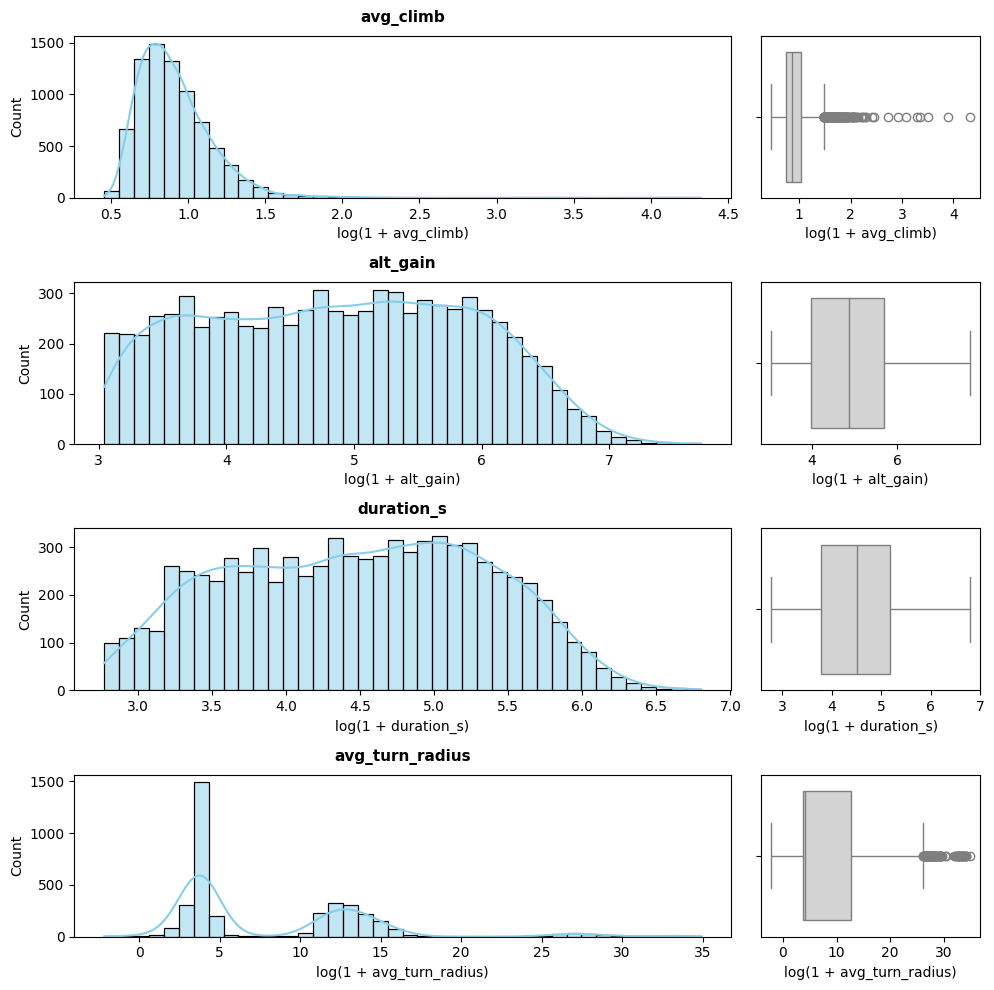

In [ ]:
# 5.1 Visual EDA of thermals_master.csv (distributions of key numeric columns)

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load thermals master file
thermals_master = pd.read_csv("Flight data/thermals/thermals_master.csv", parse_dates=["start_datetime"])

# Pick numeric columns for EDA
numeric_cols = ["avg_climb", "alt_gain", "duration_s", "avg_turn_radius"]

# Apply log1p (log(1+x)) to avoid issues with 0 or negative values
log_df = thermals_master[numeric_cols].applymap(
    lambda x: np.log1p(x) if pd.notnull(x) and x > -1 else np.nan
)

# Create a grid: rows = variables, 2 columns (hist + boxplot)
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(10,10), 
                         gridspec_kw={'width_ratios': [3, 1]})

for i, col in enumerate(numeric_cols):
    # Histogram
    sns.histplot(log_df[col], bins=40, kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_xlabel(f"log(1 + {col})")

    # Boxplot
    sns.boxplot(x=log_df[col], ax=axes[i, 1], color="lightgrey")
    axes[i, 1].set_xlabel(f"log(1 + {col})")

    # Row headline
    axes[i, 0].set_title(f"{col}", fontsize=11, fontweight="bold", loc="center", pad=10)
    axes[i, 1].set_title("")

# Global adjustments
plt.tight_layout()
plt.show()

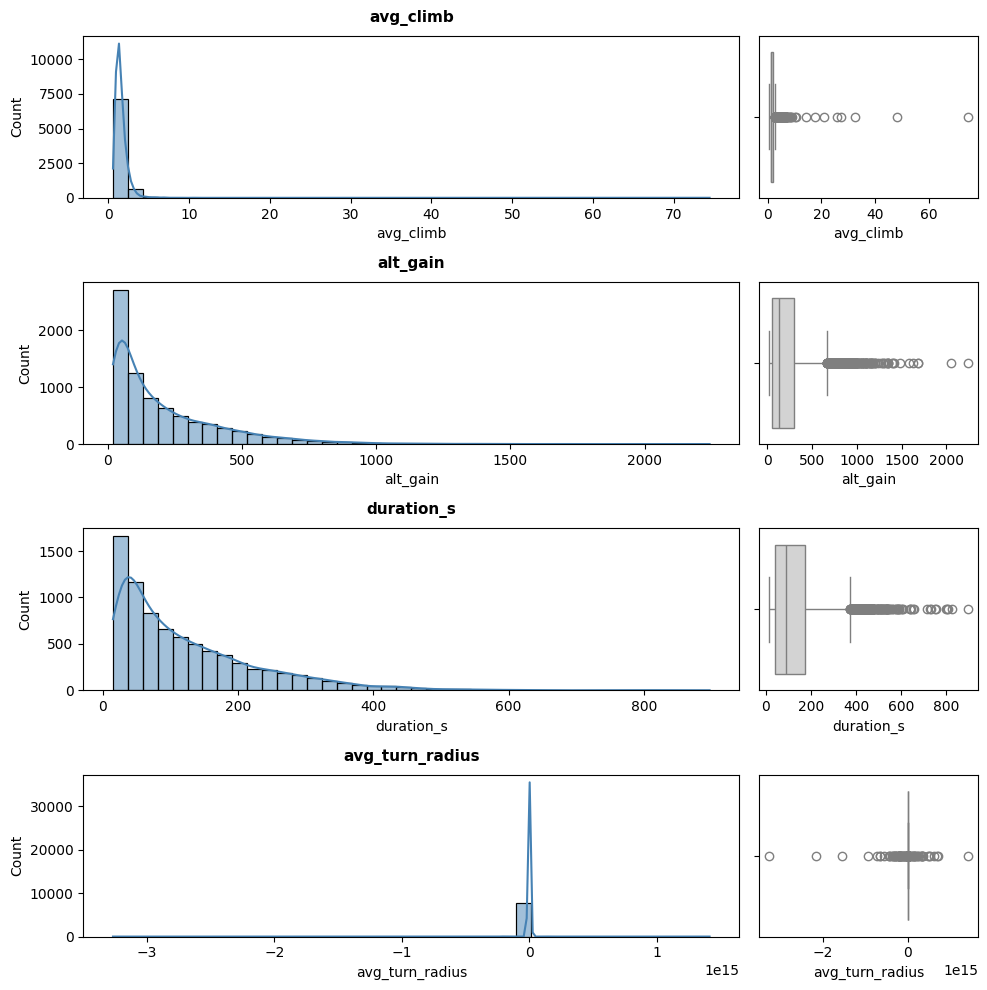

In [ ]:
# 5.2 Visual EDA of thermals_master.csv (distributions of key numeric columns)


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load thermals master file
thermals_master = pd.read_csv("Flight data/thermals/thermals_master.csv", parse_dates=["start_datetime"])

# Pick numeric columns for EDA (raw, no log)
numeric_cols = ["avg_climb", "alt_gain", "duration_s", "avg_turn_radius"]

# Create a grid: rows = variables, 2 columns (hist + boxplot)
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(10,10), 
                         gridspec_kw={'width_ratios': [3, 1]})

for i, col in enumerate(numeric_cols):
    # Histogram
    sns.histplot(thermals_master[col], bins=40, kde=True, ax=axes[i, 0], color="steelblue")
    axes[i, 0].set_xlabel(f"{col}")

    # Boxplot
    sns.boxplot(x=thermals_master[col], ax=axes[i, 1], color="lightgrey")
    axes[i, 1].set_xlabel(f"{col}")

    # Row headline
    axes[i, 0].set_title(f"{col}", fontsize=11, fontweight="bold", loc="center", pad=10)
    axes[i, 1].set_title("")

# Global adjustments
plt.tight_layout()
plt.show()

In [14]:
display(thermals_master.head())

display(df.head())

,flight_id,start_datetime,start_time,end_time,duration_s,avg_climb,max_climb,climb_std,avg_turn_radius,avg_turn,turn_std,lat_center,lon_center,entry_alt,exit_alt,entry_agl,exit_agl,entry_terrain_alt,alt_gain,thermal_quality
0,3104688,2022-07-20 11:10:16,1059,1262,168,1.496882,3.2,0.621743,725868.224770,-15.967174,5.119872,46.780453,13.114267,2372,2626,281.0,311.0,2091.0,255.0,123.574026
1,3104688,2022-07-20 11:20:21,1664,1759,42,1.009508,1.6,0.677777,43.126468,-2.295794,4.480117,46.772120,13.060872,2187,2211,245.0,277.0,1942.0,46.0,13.552941
2,3104688,2022-07-20 11:40:11,2854,2898,35,1.132334,2.0,0.426736,-56.986478,-10.823968,4.051487,46.783868,13.029293,2210,2251,196.0,196.0,2014.0,40.0,18.014286
3,3104688,2022-07-20 11:41:45,2948,3267,182,1.706906,0.4,0.774673,-233879.923718,13.528673,4.399586,46.786746,13.026027,2224,2456,210.0,210.0,2014.0,319.0,0.400000
4,3104688,2022-07-20 11:51:12,3515,3693,148,1.041059,1.8,0.623659,-43.342731,-16.100588,6.040873,46.777378,13.013615,2037,2195,321.0,328.0,1716.0,158.0,9.969231


,lat,lon,alt,datetime,flight_id,time_sec,time_min,terrain_alt,agl,climb_rate,climb_rate_smooth,bearing,turn_rate,turn_rate_smooth,ground_speed,ang_vel,turn_radius,thermal_flag_smooth,thermal_segment
0,47.597833,13.953983,1961,2023-07-27 12:24:44,3253765,0,0.000000,1929,32,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,0,NaN
1,47.597800,13.954017,1960,2023-07-27 12:24:45,3253765,1,0.016667,1929,31,-1.0,NaN,146.006997,0.000000,NaN,4.470475,NaN,NaN,0,NaN
2,47.597800,13.954033,1961,2023-07-27 12:24:46,3253765,2,0.033333,1929,32,1.0,NaN,89.999994,-56.007004,-65.201399,1.249703,-1.137979,-1.098177,0,NaN
3,47.597800,13.954033,1961,2023-07-27 12:24:47,3253765,3,0.050000,1929,32,0.0,-0.2,0.000000,-89.999994,-65.201399,0.000000,-1.137979,-0.000000,0,NaN
4,47.597783,13.954033,1961,2023-07-27 12:24:48,3253765,4,0.066667,1929,32,0.0,0.0,180.000000,-180.000000,-65.201399,1.853249,-1.137979,-1.628544,0,NaN


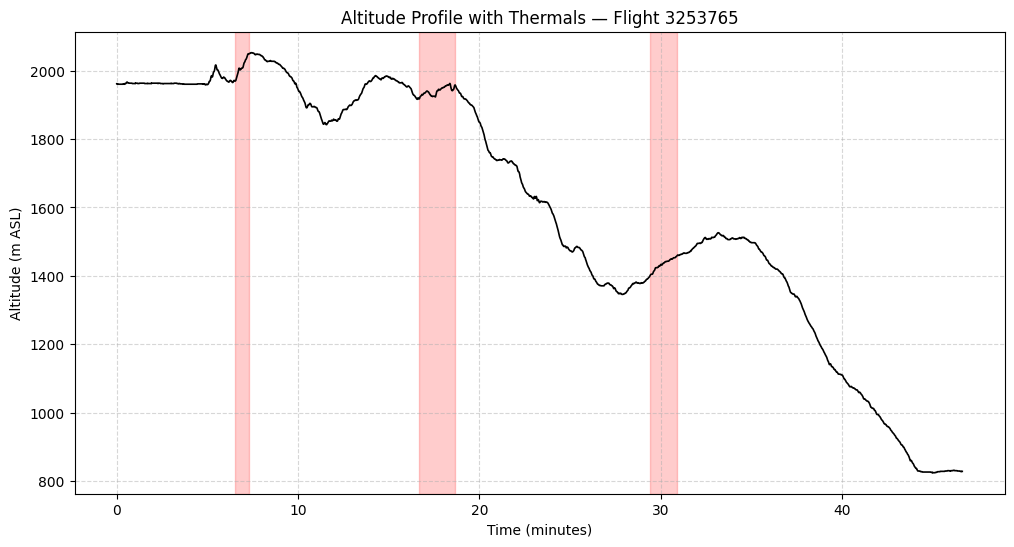

In [15]:
import matplotlib.pyplot as plt

# Identify the current flight ID from df
current_flight_id = df["flight_id"].iloc[0]

# Filter thermals_master to only this flight
filtered_thermals = thermals_master[thermals_master["flight_id"] == current_flight_id]

# Plot altitude profile with thermal shading
plt.figure(figsize=(12, 6))
plt.plot(df["time_min"], df["alt"], color="black", linewidth=1.2)

# Add shading for thermals belonging to this flight
for _, row in filtered_thermals.iterrows():
    plt.axvspan(
        row["start_time"] / 60,  # seconds → minutes
        row["end_time"] / 60,
        color="red",
        alpha=0.2
    )

plt.xlabel("Time (minutes)")
plt.ylabel("Altitude (m ASL)")
plt.title(f"Altitude Profile with Thermals — Flight {current_flight_id}")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

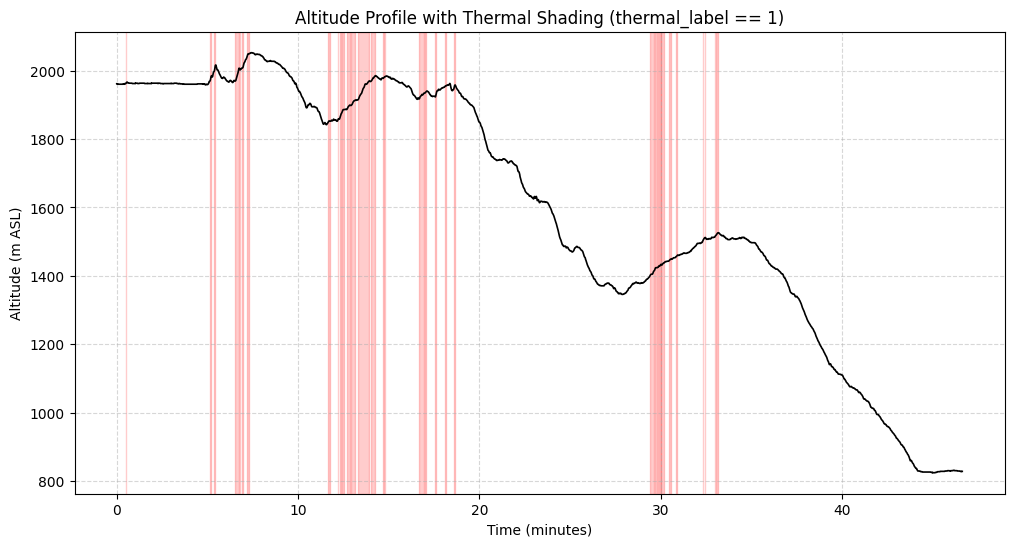

In [ ]:


plt.figure(figsize=(12, 6))
plt.plot(df["time_min"], df["alt"], color="black", linewidth=1.2)

# Identify consecutive segments where thermal_label == 1
mask = df["thermal_segment"] >= 1
segments = []
start = None

for i, flag in enumerate(mask):
    if flag and start is None:
        start = df["time_min"].iloc[i]
    elif not flag and start is not None:
        end = df["time_min"].iloc[i - 1]
        segments.append((start, end))
        start = None
# handle case if last segment continues to end
if start is not None:
    end = df["time_min"].iloc[-1]
    segments.append((start, end))

# Plot shaded regions for all thermal segments
for start, end in segments:
    plt.axvspan(start, end, color="red", alpha=0.2)

plt.xlabel("Time (minutes)")
plt.ylabel("Altitude (m ASL)")
plt.title("Altitude Profile with Thermal Shading (thermal_label == 1)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

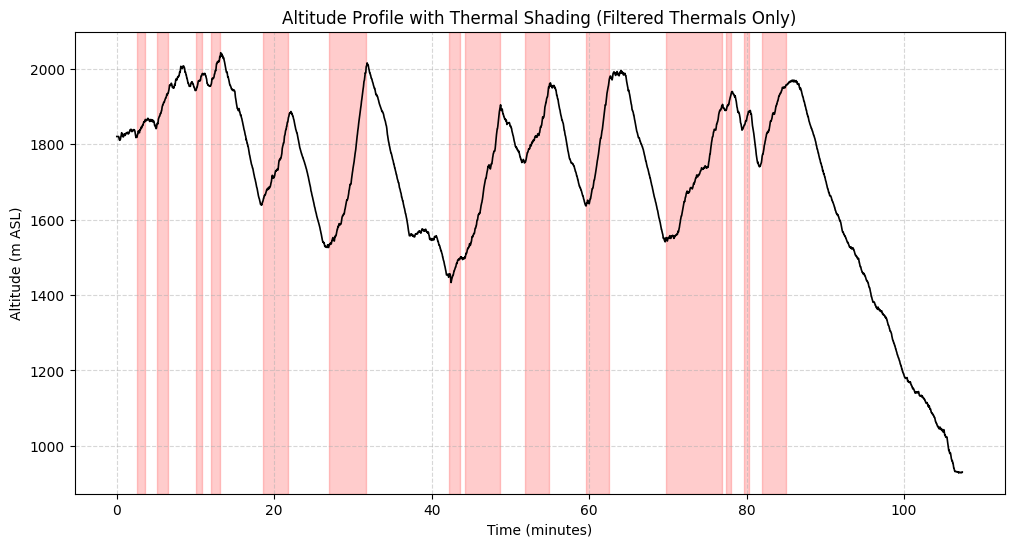

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df["time_min"], df["alt"], color="black", linewidth=1.2)

# Highlight only thermals in filtered thermals_master df
for _, row in thermals_master.iterrows():
    plt.axvspan(
        row["start_time"] / 60,  # convert seconds → minutes
        row["end_time"] / 60,
        color="red",
        alpha=0.2
    )

plt.xlabel("Time (minutes)")
plt.ylabel("Altitude (m ASL)")
plt.title("Altitude Profile with Thermal Shading (Filtered Thermals Only)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

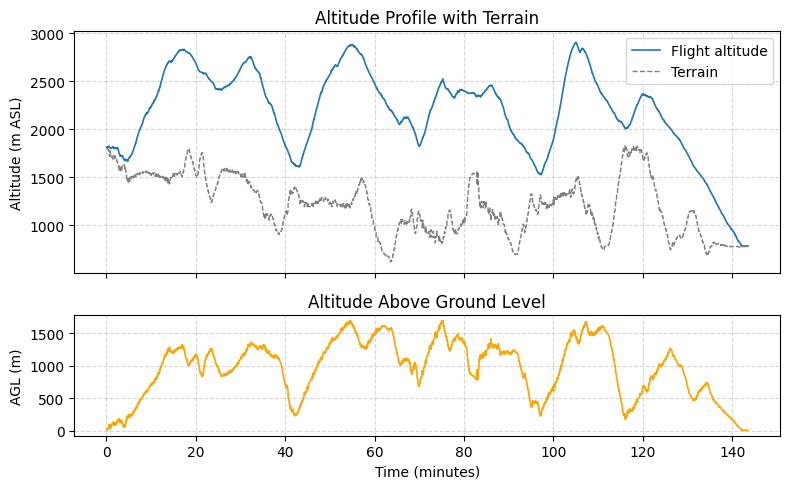

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


# Ensure AGL column exists
df["AGL"] = df["alt"] - df["terrain_alt"]

# Create subplots with custom height ratios
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(8, 5), sharex=True,
    gridspec_kw={"height_ratios": [2, 1]}  # top twice as tall as bottom
)

# --- Plot 1: Absolute altitudes (ASL) ---
sns.lineplot(x="time_min", y="alt", data=df, linewidth=1.2, label="Flight altitude", ax=ax1)
sns.lineplot(x="time_min", y="terrain_alt", data=df, linewidth=1.0, color="grey", linestyle="--", label="Terrain", ax=ax1)

ax1.set_ylabel("Altitude (m ASL)")
ax1.set_title("Altitude Profile with Terrain")
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.5)

# --- Plot 2: Altitude Above Ground Level (AGL) ---
sns.lineplot(x="time_min", y="AGL", data=df, linewidth=1.2, color="orange", ax=ax2)

ax2.set_xlabel("Time (minutes)")
ax2.set_ylabel("AGL (m)")
ax2.set_title("Altitude Above Ground Level")
ax2.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

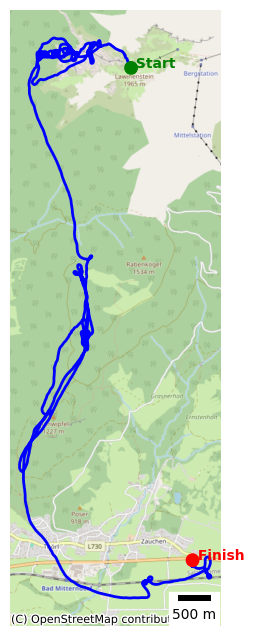

In [19]:


# Build LineString + Start/End points
line = LineString(zip(df["lon"], df["lat"]))
start = Point(df["lon"].iloc[0], df["lat"].iloc[0])
end   = Point(df["lon"].iloc[-1], df["lat"].iloc[-1])

gdf_line = gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326")
gdf_points = gpd.GeoDataFrame(geometry=[start, end], crs="EPSG:4326")

# Reproject to Web Mercator (for basemap)
gdf_line = gdf_line.to_crs(epsg=3857)
gdf_points = gdf_points.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
gdf_line.plot(ax=ax, linewidth=2, color="blue", label="Flight path")
gdf_points.plot(ax=ax, color=["green", "red"], markersize=80, zorder=5)

# Add basemap
ctx.add_basemap(ax, crs=gdf_line.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Add labels for start/finish
ax.text(gdf_points.geometry.iloc[0].x, gdf_points.geometry.iloc[0].y, " Start", 
        fontsize=10, color="green", weight="bold")
ax.text(gdf_points.geometry.iloc[1].x, gdf_points.geometry.iloc[1].y, " Finish", 
        fontsize=10, color="red", weight="bold")

# Scale bar
scalebar = ScaleBar(1, units="m", location="lower right")
ax.add_artist(scalebar)

#ax.set_title("Paragliding Flight Path with Start/Finish", fontsize=14)
ax.set_axis_off()
plt.show()

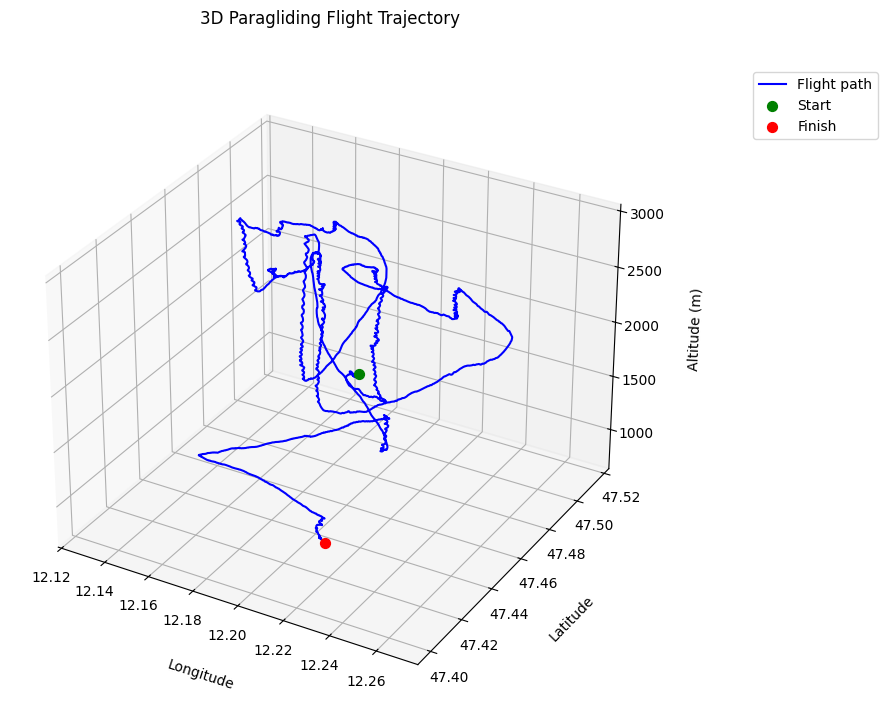

In [161]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract coords
lon = df["lon"].values
lat = df["lat"].values
alt = df["alt"].values

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot flight path
ax.plot(lon, lat, alt, color="blue", linewidth=1.5, label="Flight path")

# Start (green) and Finish (red)
ax.scatter(lon[0], lat[0], alt[0], color="green", s=50, label="Start")
ax.scatter(lon[-1], lat[-1], alt[-1], color="red", s=50, label="Finish")

# Labels
ax.set_xlabel("Longitude", labelpad=15)
ax.set_ylabel("Latitude", labelpad=15)
ax.set_zlabel("Altitude (m)", labelpad=15)
ax.set_title("3D Paragliding Flight Trajectory", pad=30)

# Legend outside
ax.legend(loc="upper left", bbox_to_anchor=(1.15, 1))

# Adjust layout with extra padding
plt.tight_layout()
plt.subplots_adjust(left=0.01, right=0.9, top=0.9, bottom=0.1)  

plt.show()

In [12]:
display(df.head())

,lat,lon,alt,datetime,flight_id,time_sec,time_min,terrain_alt,agl,climb_rate,climb_rate_smooth,bearing,turn_rate,turn_rate_smooth,ground_speed,ang_vel,turn_radius,thermal_flag_smooth,thermal_segment
0,47.597833,13.953983,1961,2023-07-27 12:24:44,3253765,0,0.000000,1929,32,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,0,NaN
1,47.597800,13.954017,1960,2023-07-27 12:24:45,3253765,1,0.016667,1929,31,-1.0,NaN,146.006997,0.000000,NaN,4.470475,NaN,NaN,0,NaN
2,47.597800,13.954033,1961,2023-07-27 12:24:46,3253765,2,0.033333,1929,32,1.0,NaN,89.999994,-56.007004,-65.201399,1.249703,-1.137979,-1.098177,0,NaN
3,47.597800,13.954033,1961,2023-07-27 12:24:47,3253765,3,0.050000,1929,32,0.0,-0.2,0.000000,-89.999994,-65.201399,0.000000,-1.137979,-0.000000,0,NaN
4,47.597783,13.954033,1961,2023-07-27 12:24:48,3253765,4,0.066667,1929,32,0.0,0.0,180.000000,-180.000000,-65.201399,1.853249,-1.137979,-1.628544,0,NaN


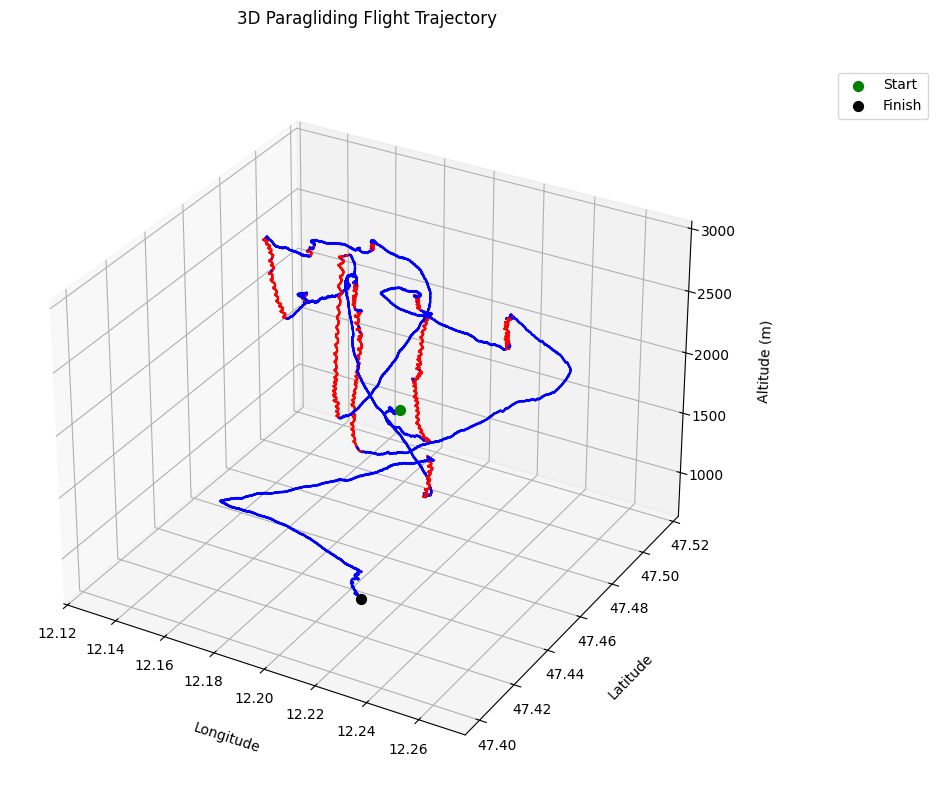

In [162]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Extract coords
lon = df["lon"].values
lat = df["lat"].values
alt = df["alt"].values
thermal = df["thermal_flag_smooth"].values  # 0 or 1

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# --- Plot path segment by segment ---
for i in range(1, len(df)):
    color = "red" if thermal[i] == 1 else "blue"
    ax.plot(
        lon[i-1:i+1],
        lat[i-1:i+1],
        alt[i-1:i+1],
        color=color,
        linewidth=1.5
    )

# Start (green) and Finish (black)
ax.scatter(lon[0], lat[0], alt[0], color="green", s=50, label="Start")
ax.scatter(lon[-1], lat[-1], alt[-1], color="black", s=50, label="Finish")

# Labels
ax.set_xlabel("Longitude", labelpad=15)
ax.set_ylabel("Latitude", labelpad=15)
ax.set_zlabel("Altitude (m)", labelpad=15)
ax.set_title("3D Paragliding Flight Trajectory", pad=30)

# Legend outside
ax.legend(loc="upper left", bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()